In [2]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 16.9 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer, precision_score, recall_score, f1_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from imblearn.over_sampling import SMOTE
import optuna
from sklearn.decomposition import PCA

In [4]:
# Load the dataset
file_path = "/content/mitmnew.pcap_Flow.csv"
data = pd.read_csv(file_path)

In [5]:
# Display dataset info
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314 entries, 0 to 313
Data columns (total 84 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Flow ID            314 non-null    object 
 1   Src IP             314 non-null    object 
 2   Src Port           314 non-null    int64  
 3   Dst IP             314 non-null    object 
 4   Dst Port           314 non-null    int64  
 5   Protocol           314 non-null    int64  
 6   Timestamp          314 non-null    object 
 7   Flow Duration      314 non-null    int64  
 8   Tot Fwd Pkts       314 non-null    int64  
 9   Tot Bwd Pkts       314 non-null    int64  
 10  TotLen Fwd Pkts    314 non-null    int64  
 11  TotLen Bwd Pkts    314 non-null    int64  
 12  Fwd Pkt Len Max    314 non-null    int64  
 13  Fwd Pkt Len Min    314 non-null    int64  
 14  Fwd Pkt Len Mean   314 non-null    float64
 15  Fwd Pkt Len Std    314 non-null    float64
 16  Bwd Pkt Len Max    314 non

In [6]:
print(data['Label'].value_counts())

Label
MITM      206
Benign    108
Name: count, dtype: int64


In [7]:
# Convert labels to binary: 0 for Benign, 1 for attacks
data['Label'] = data['Label'].apply(lambda x: 0 if x == 'Benign' else 1)

In [8]:
# Drop unnecessary columns
columns_to_drop = ['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Protocol', 'Timestamp']
data = data.drop(columns=columns_to_drop, errors='ignore')

# Check if any column is non-numeric
non_numeric_columns = data.select_dtypes(exclude=['number']).columns
print("Non-numeric columns:", non_numeric_columns)

# Handle missing values for numeric columns only
numeric_columns = data.select_dtypes(include=['number']).columns
data[numeric_columns] = data[numeric_columns].fillna(data[numeric_columns].mean())

# Check the dataset again
print(data.info())

Non-numeric columns: Index([], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 314 entries, 0 to 313
Data columns (total 77 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Flow Duration      314 non-null    int64  
 1   Tot Fwd Pkts       314 non-null    int64  
 2   Tot Bwd Pkts       314 non-null    int64  
 3   TotLen Fwd Pkts    314 non-null    int64  
 4   TotLen Bwd Pkts    314 non-null    int64  
 5   Fwd Pkt Len Max    314 non-null    int64  
 6   Fwd Pkt Len Min    314 non-null    int64  
 7   Fwd Pkt Len Mean   314 non-null    float64
 8   Fwd Pkt Len Std    314 non-null    float64
 9   Bwd Pkt Len Max    314 non-null    int64  
 10  Bwd Pkt Len Min    314 non-null    int64  
 11  Bwd Pkt Len Mean   314 non-null    float64
 12  Bwd Pkt Len Std    314 non-null    float64
 13  Flow Byts/s        314 non-null    float64
 14  Flow Pkts/s        314 non-null    float64
 15  Flow IAT Mean      314 non-

In [9]:
# Split into features (X) and target (y)
X = data.drop('Label', axis=1)  # Features
y = data['Label']  # Target

In [10]:
# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Testing set size:", X_test.shape)

Training set size: (251, 76)
Testing set size: (63, 76)


In [11]:
# Check for NaN values
print("NaN values in X_train:", np.isnan(X_train).sum().sum())
print("NaN values in X_test:", np.isnan(X_test).sum().sum())

# Check for infinity values
print("Infinity values in X_train:", np.isinf(X_train).sum().sum())
print("Infinity values in X_test:", np.isinf(X_test).sum().sum())

NaN values in X_train: 0
NaN values in X_test: 0
Infinity values in X_train: 2
Infinity values in X_test: 0


In [12]:
# Replace NaN and infinity with the mean of the column
X_train = X_train.replace([np.inf, -np.inf], np.nan)
X_test = X_test.replace([np.inf, -np.inf], np.nan)

# Fill NaN with column mean
X_train = X_train.fillna(X_train.mean())
X_test = X_test.fillna(X_test.mean())


In [13]:
# Print original class distribution
print("Original class distribution:")
print(y_train.value_counts())

Original class distribution:
Label
1    167
0     84
Name: count, dtype: int64


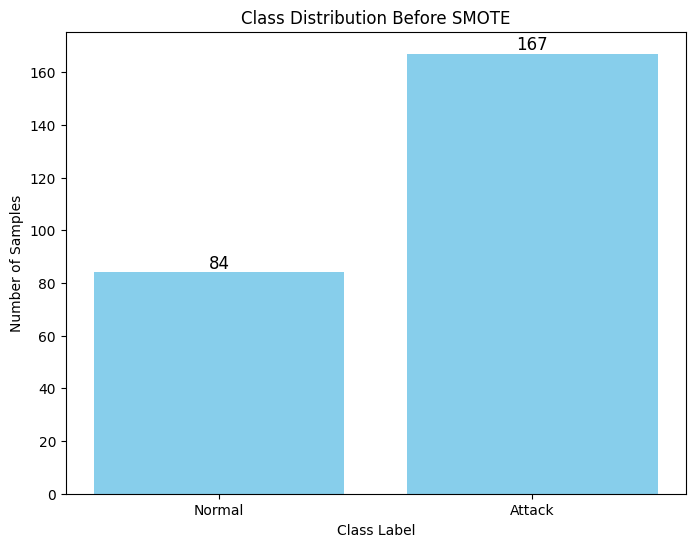

In [14]:
# Plot class distribution before SMOTE
plt.figure(figsize=(8, 6))
value_counts = y_train.value_counts().sort_index()
bars = plt.bar(range(len(value_counts)), value_counts, color='skyblue')

# Add numbers on top of each bar
for i, count in enumerate(value_counts):
    plt.annotate(str(count), xy=(i, count), ha='center', va='bottom', fontsize=12)

plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("Class Distribution Before SMOTE")
plt.xticks([0, 1], ['Normal', 'Attack'])
plt.show()

In [15]:
# Apply SMOTE to balance the training set
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

# Check the class distribution after SMOTE
print("Class distribution after SMOTE:")
print(y_train_balanced.value_counts())

Class distribution after SMOTE:
Label
1    167
0    167
Name: count, dtype: int64


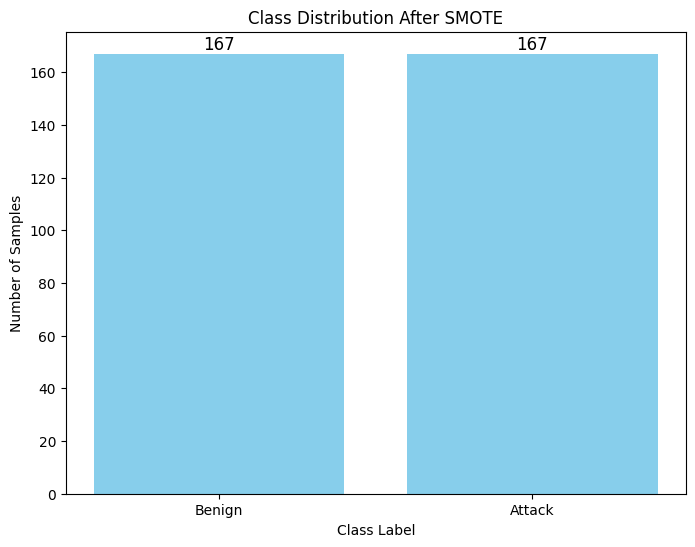

In [16]:
# Plot class distribution after SMOTE
plt.figure(figsize=(8, 6))
value_counts = y_train_balanced.value_counts().sort_index()
bars = plt.bar(range(len(value_counts)), value_counts, color='skyblue')

# Add numbers on top of each bar
for i, count in enumerate(value_counts):
    plt.annotate(str(count), xy=(i, count), ha='center', va='bottom', fontsize=12)

plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("Class Distribution After SMOTE")
plt.xticks([0, 1], ['Benign', 'Attack'])  # Adjust labels if necessary
plt.show()


In [17]:
def scale_data(X_train, X_test, scale_data=True):
    """
    Scales the data if scale_data is True.
    """
    if scale_data:
        scaler = MinMaxScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

        X_test_scaled = scaler.transform(X_test)
        X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)
    else:
        X_train_scaled = X_train
        X_test_scaled = X_test

    return X_train_scaled, X_test_scaled, scaler

In [18]:
def compute_mutual_info(X_train_scaled, y_train):
    """
    Computes mutual information (MI) scores for the features in X_train.
    """
    mi_scores = mutual_info_classif(X_train_scaled, y_train, random_state=42)

    # Create MI DataFrame with rank
    mi_df = pd.DataFrame({
        'Feature': X_train_scaled.columns,
        'MI_Score': mi_scores
    }).sort_values('MI_Score', ascending=False).reset_index(drop=True)
    mi_df['Rank'] = mi_df.index + 1

    return mi_df

[INFO] Top 20 Features by Mutual Information Scores:
             Feature  MI_Score  Rank
0       Flow IAT Std  0.162532     1
1       Flow IAT Max  0.159587     2
2        Fwd IAT Std  0.157919     3
3        Fwd IAT Min  0.139320     4
4      Flow IAT Mean  0.137490     5
5        Fwd IAT Max  0.128477     6
6    TotLen Bwd Pkts  0.127078     7
7       Fwd IAT Mean  0.125659     8
8   Subflow Bwd Byts  0.123455     9
9        Flow Pkts/s  0.114215    10
10       Bwd IAT Max  0.112434    11
11     Flow Duration  0.108749    12
12        Bwd Pkts/s  0.105845    13
13          Idle Max  0.098786    14
14        Fwd Pkts/s  0.097279    15
15      Bwd IAT Mean  0.091352    16
16       Fwd IAT Tot  0.090450    17
17       Pkt Len Max  0.087709    18
18      Pkt Size Avg  0.079529    19
19          Idle Std  0.078637    20


/tmp/ipython-input-3912260746.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='MI_Score', y='Feature', data=top_k, palette='viridis')


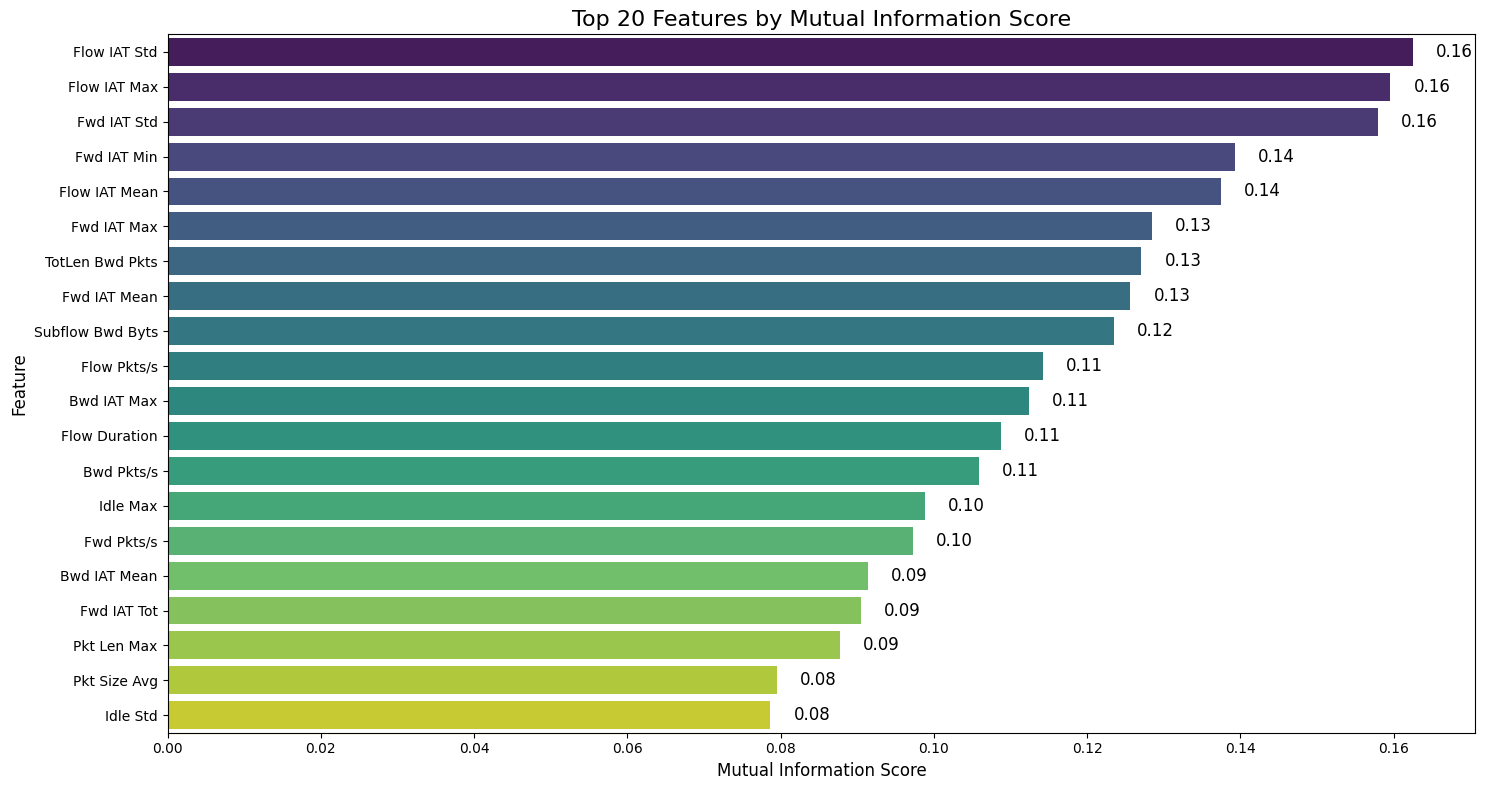

[INFO] Selected 54 Features:
['Flow IAT Std', 'Flow IAT Max', 'Fwd IAT Std', 'Fwd IAT Min', 'Flow IAT Mean', 'Fwd IAT Max', 'TotLen Bwd Pkts', 'Fwd IAT Mean', 'Subflow Bwd Byts', 'Flow Pkts/s', 'Bwd IAT Max', 'Flow Duration', 'Bwd Pkts/s', 'Idle Max', 'Fwd Pkts/s', 'Bwd IAT Mean', 'Fwd IAT Tot', 'Pkt Len Max', 'Pkt Size Avg', 'Idle Std', 'Bwd Header Len', 'Fwd Pkt Len Std', 'Flow IAT Min', 'Bwd IAT Min', 'Flow Byts/s', 'Idle Min', 'Pkt Len Mean', 'Bwd IAT Tot', 'Pkt Len Std', 'Bwd Seg Size Avg', 'ACK Flag Cnt', 'Fwd Pkt Len Mean', 'Init Bwd Win Byts', 'Bwd Pkt Len Max', 'Fwd Pkt Len Max', 'TotLen Fwd Pkts', 'Subflow Fwd Byts', 'Bwd Pkt Len Min', 'PSH Flag Cnt', 'Bwd Pkt Len Std', 'Bwd IAT Std', 'Idle Mean', 'Subflow Fwd Pkts', 'Fwd Pkts/b Avg', 'Pkt Len Min', 'Pkt Len Var', 'Fwd Pkt Len Min', 'Fwd Act Data Pkts', 'Fwd Header Len', 'Subflow Bwd Pkts', 'Tot Bwd Pkts', 'Bwd Pkt Len Mean', 'Fwd Seg Size Avg', 'Fwd Blk Rate Avg']
[INFO] Top 20 Features by Mutual Information Scores:
        

/tmp/ipython-input-3912260746.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x='MI_Score', y='Feature', data=top_k, palette='viridis')


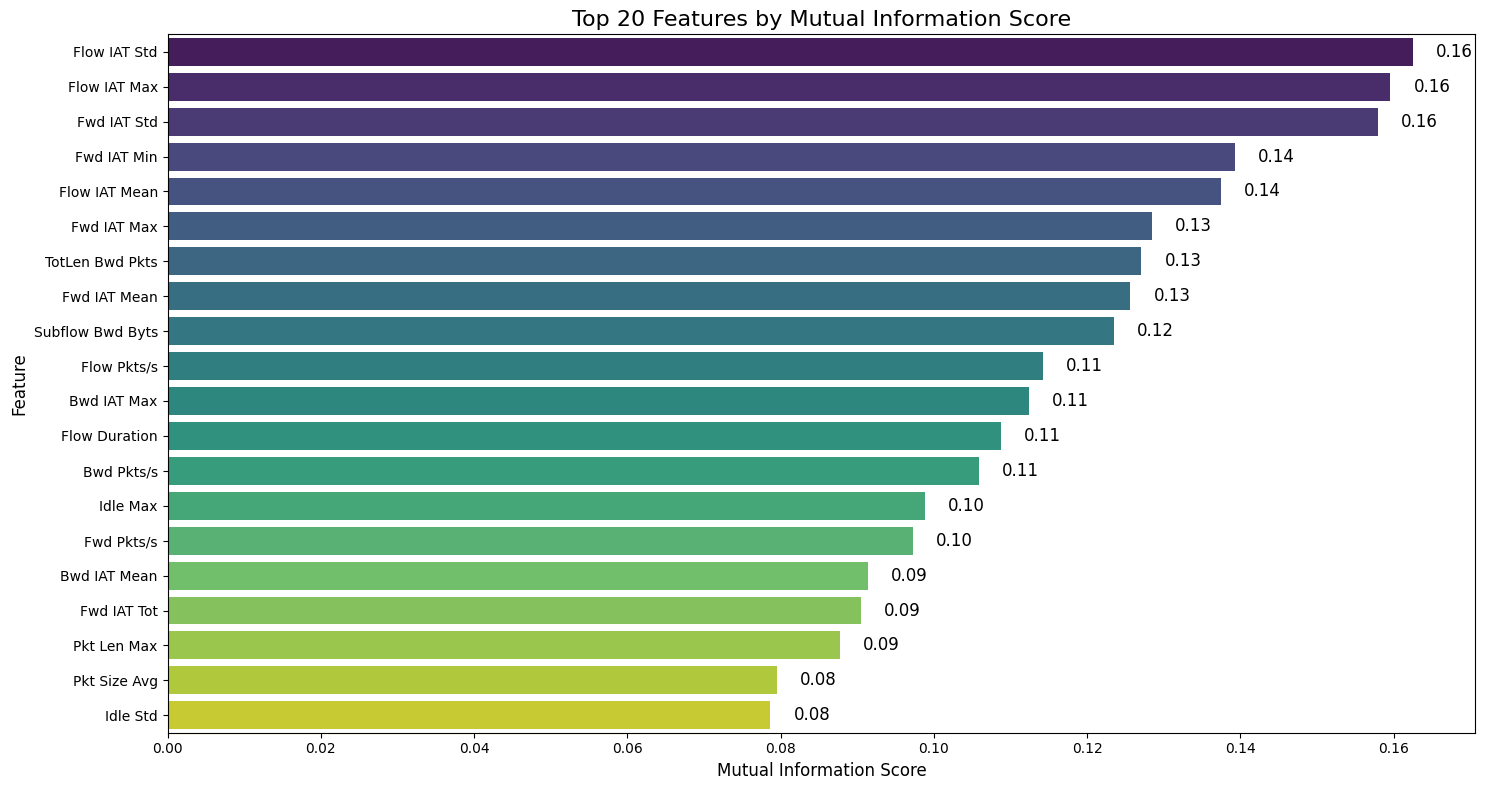

[INFO] Selected 54 Features:
['Flow IAT Std', 'Flow IAT Max', 'Fwd IAT Std', 'Fwd IAT Min', 'Flow IAT Mean', 'Fwd IAT Max', 'TotLen Bwd Pkts', 'Fwd IAT Mean', 'Subflow Bwd Byts', 'Flow Pkts/s', 'Bwd IAT Max', 'Flow Duration', 'Bwd Pkts/s', 'Idle Max', 'Fwd Pkts/s', 'Bwd IAT Mean', 'Fwd IAT Tot', 'Pkt Len Max', 'Pkt Size Avg', 'Idle Std', 'Bwd Header Len', 'Fwd Pkt Len Std', 'Flow IAT Min', 'Bwd IAT Min', 'Flow Byts/s', 'Idle Min', 'Pkt Len Mean', 'Bwd IAT Tot', 'Pkt Len Std', 'Bwd Seg Size Avg', 'ACK Flag Cnt', 'Fwd Pkt Len Mean', 'Init Bwd Win Byts', 'Bwd Pkt Len Max', 'Fwd Pkt Len Max', 'TotLen Fwd Pkts', 'Subflow Fwd Byts', 'Bwd Pkt Len Min', 'PSH Flag Cnt', 'Bwd Pkt Len Std', 'Bwd IAT Std', 'Idle Mean', 'Subflow Fwd Pkts', 'Fwd Pkts/b Avg', 'Pkt Len Min', 'Pkt Len Var', 'Fwd Pkt Len Min', 'Fwd Act Data Pkts', 'Fwd Header Len', 'Subflow Bwd Pkts', 'Tot Bwd Pkts', 'Bwd Pkt Len Mean', 'Fwd Seg Size Avg', 'Fwd Blk Rate Avg']


In [20]:
def plot_top_features(mi_df, top_n=20):
    """
    Plots the top_n features based on their Mutual Information (MI) scores and adds the MI scores as numbers above each bar.
    """
    top_k = mi_df.head(top_n)

    plt.figure(figsize=(15, 8))
    bars = sns.barplot(x='MI_Score', y='Feature', data=top_k, palette='viridis')

    # Add numbers on top of each bar with adjusted space
    for p in bars.patches:
        # Annotate with a little more horizontal space
        bars.annotate(f'{p.get_width():.2f}',
                      (p.get_width(), p.get_y() + p.get_height() / 2),
                      ha='center', va='center', fontsize=12, color='black',
                      xytext=(30, 0), textcoords='offset points')  # Increase the offset here

    plt.title(f'Top {top_n} Features by Mutual Information Score', fontsize=16)
    plt.xlabel('Mutual Information Score', fontsize=12)
    plt.ylabel('Feature', fontsize=12)
    plt.tight_layout()
    plt.show()

# First, scale the data and get the scaler
X_train_scaled, X_test_scaled, scaler = scale_data(X_train_balanced, X_test, scale_data=True)

# Then, compute mutual information
mi_df = compute_mutual_info(X_train_scaled, y_train_balanced)

# Print Top 20 Features based on MI Scores
print("[INFO] Top 20 Features by Mutual Information Scores:")
print(mi_df.head(20))

# Plot the top 20 features
plot_top_features(mi_df, top_n=20)

# Select features based on the mutual information threshold
selected_features = mi_df[mi_df['MI_Score'] >= 0.01]['Feature'].tolist()

# Now select the features from the original data
X_train_selected = X_train_balanced[selected_features]
X_test_selected = X_test[selected_features]

# Ensure X_train_selected has the same columns as X_test_selected
X_train_selected = X_train_balanced[X_test_selected.columns]  # Align training data to test features

# Apply scaling to both the train and test data using the same scaler (that was used previously)
X_train_scaled = scaler.fit_transform(X_train_selected)  # Fit and transform the train data
X_test_scaled = scaler.transform(X_test_selected)  # Transform the test data

# Print total number of selected features and their names
print(f"[INFO] Selected {len(selected_features)} Features:")
print(selected_features)

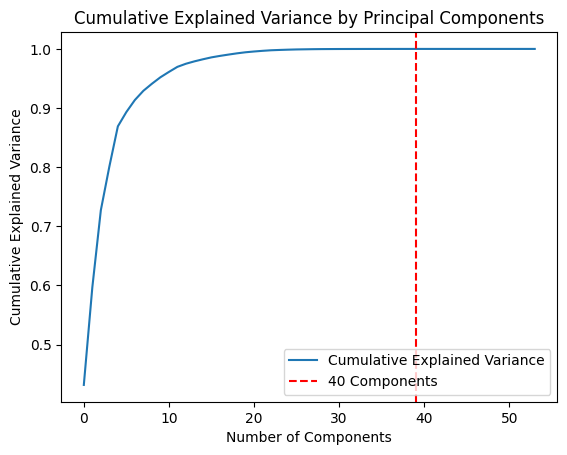

In [22]:
# Perform PCA
pca = PCA()
pca.fit(X_train_scaled)  # X_train_scaled is your training data

# Get explained variance ratio and cumulative variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = explained_variance_ratio.cumsum()

# Plot the cumulative explained variance ratio
plt.plot(cumulative_variance_ratio, label='Cumulative Explained Variance')

# Add a vertical line where the cumulative explained variance reaches 1
threshold = 1  # Target cumulative explained variance (1 means 100% variance)
# Find the index where cumulative variance is close to 1.0
component_count = next(i for i, val in enumerate(cumulative_variance_ratio) if np.isclose(val, threshold))

# Plot the vertical line
plt.axvline(x=component_count, color='red', linestyle='--', label=f'{component_count+1} Components')

# Labeling the axes
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.legend(loc='best')
plt.title('Cumulative Explained Variance by Principal Components')

# Show the plot
plt.show()

In [23]:
# Metrics calculation function
def calculate_metrics(y_true, y_pred, conf_matrix):
    tn, fp, fn, tp = conf_matrix.ravel()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    f1 = f1_score(y_true, y_pred)

    metrics = {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "Specificity": specificity,
        "F1-score": f1
    }

    return metrics

def display_metrics(metrics):
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name.ljust(12)}: {metric_value * 100:.2f}%")


In [24]:
 # Train a base Decision Tree model before hyperparameter tuning
print("Training base Decision Tree model...")
dt_base = DecisionTreeClassifier(random_state=42)
dt_base.fit(X_train_scaled, y_train_balanced)
dt_base_preds = dt_base.predict(X_test_scaled)

Training base Decision Tree model...


In [25]:
# Generate and display metrics and confusion matrix for base model
print("\nBase Decision Tree Performance:")
# Use the `digits` parameter to format precision, recall, and f1-score to 4 decimal places
print(classification_report(y_test, dt_base_preds, digits=4))

# Print accuracy with 4 decimal places
accuracy = accuracy_score(y_test, dt_base_preds)
print(f"Accuracy: {accuracy:.4f}")

# Confusion matrix
conf_matrix_base = confusion_matrix(y_test, dt_base_preds)
print("Confusion Matrix:")
print(conf_matrix_base)


Base Decision Tree Performance:
              precision    recall  f1-score   support

           0     0.5517    0.6667    0.6038        24
           1     0.7647    0.6667    0.7123        39

    accuracy                         0.6667        63
   macro avg     0.6582    0.6667    0.6581        63
weighted avg     0.6836    0.6667    0.6710        63

Accuracy: 0.6667
Confusion Matrix:
[[16  8]
 [13 26]]


Text(0.5, 1.0, 'Confusion Matrix - Count (Base DT)')

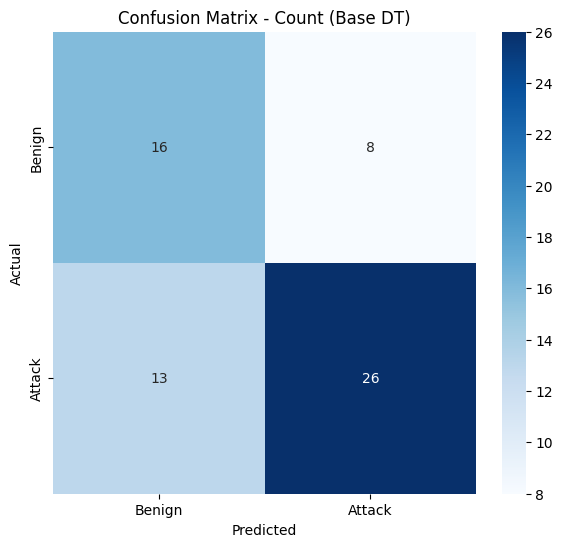

In [26]:
# Display confusion matrix as count
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.heatmap(conf_matrix_base, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Benign', 'Attack'], yticklabels=['Benign', 'Attack'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Count (Base DT)')

In [27]:
 # Define the Optuna objective function for hyperparameter tuning
def objective(trial):
    # Define hyperparameters to optimize
    max_depth = trial.suggest_int('max_depth', 5, 50)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 20)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy'])

    # Create and train the Decision Tree model
    dt = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        criterion=criterion,
        random_state=42
    )

    # Use cross-validation to evaluate model performance
    score = 0
    try:
        dt.fit(X_train_scaled, y_train_balanced)
        y_pred = dt.predict(X_test_scaled)
        score = f1_score(y_test, y_pred)  # Optimize for F1 score
    except Exception as e:
        print(f"Exception in Optuna trial: {e}")
        return 0.0

    return score

# Run Optuna optimization
print("\nStarting Optuna hyperparameter optimization with 15 trials...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=15)

# Get the best hyperparameters
best_params = study.best_params
print(f"\nBest hyperparameters found: {best_params}")

# Train a new model with the best hyperparameters
print("\nTraining Decision Tree with optimized hyperparameters...")
dt_tuned = DecisionTreeClassifier(
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    criterion=best_params['criterion'],
    random_state=42
)
dt_tuned.fit(X_train_scaled, y_train_balanced)
dt_tuned_preds = dt_tuned.predict(X_test_scaled)

[I 2025-08-07 07:02:32,575] A new study created in memory with name: no-name-c237e458-ec50-49e3-bddc-a444256e9b44
[I 2025-08-07 07:02:32,599] Trial 0 finished with value: 0.64 and parameters: {'max_depth': 46, 'min_samples_split': 12, 'min_samples_leaf': 6, 'criterion': 'gini'}. Best is trial 0 with value: 0.64.
[I 2025-08-07 07:02:32,620] Trial 1 finished with value: 0.6842105263157895 and parameters: {'max_depth': 46, 'min_samples_split': 7, 'min_samples_leaf': 9, 'criterion': 'gini'}. Best is trial 1 with value: 0.6842105263157895.
[I 2025-08-07 07:02:32,641] Trial 2 finished with value: 0.6753246753246753 and parameters: {'max_depth': 47, 'min_samples_split': 9, 'min_samples_leaf': 8, 'criterion': 'gini'}. Best is trial 1 with value: 0.6842105263157895.
[I 2025-08-07 07:02:32,666] Trial 3 finished with value: 0.6753246753246753 and parameters: {'max_depth': 39, 'min_samples_split': 3, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 1 with value: 0.6842105263157895.
[I 20


Starting Optuna hyperparameter optimization with 15 trials...


[I 2025-08-07 07:02:32,803] Trial 8 finished with value: 0.5866666666666667 and parameters: {'max_depth': 27, 'min_samples_split': 4, 'min_samples_leaf': 6, 'criterion': 'entropy'}. Best is trial 4 with value: 0.7105263157894737.
[I 2025-08-07 07:02:32,827] Trial 9 finished with value: 0.6753246753246753 and parameters: {'max_depth': 20, 'min_samples_split': 9, 'min_samples_leaf': 7, 'criterion': 'gini'}. Best is trial 4 with value: 0.7105263157894737.
[I 2025-08-07 07:02:32,906] Trial 10 finished with value: 0.56 and parameters: {'max_depth': 7, 'min_samples_split': 20, 'min_samples_leaf': 3, 'criterion': 'entropy'}. Best is trial 4 with value: 0.7105263157894737.
[I 2025-08-07 07:02:32,949] Trial 11 finished with value: 0.6756756756756757 and parameters: {'max_depth': 5, 'min_samples_split': 13, 'min_samples_leaf': 10, 'criterion': 'gini'}. Best is trial 4 with value: 0.7105263157894737.
[I 2025-08-07 07:02:32,998] Trial 12 finished with value: 0.6086956521739131 and parameters: {'ma


Best hyperparameters found: {'max_depth': 32, 'min_samples_split': 6, 'min_samples_leaf': 10, 'criterion': 'gini'}

Training Decision Tree with optimized hyperparameters...


In [28]:
# Train a new model with the best hyperparameters
print("\nTraining Decision Tree with optimized hyperparameters...")
dt_tuned = DecisionTreeClassifier(
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    criterion=best_params['criterion'],
    random_state=42
)
dt_tuned.fit(X_train_scaled, y_train_balanced)
dt_tuned_preds = dt_tuned.predict(X_test_scaled)


Training Decision Tree with optimized hyperparameters...


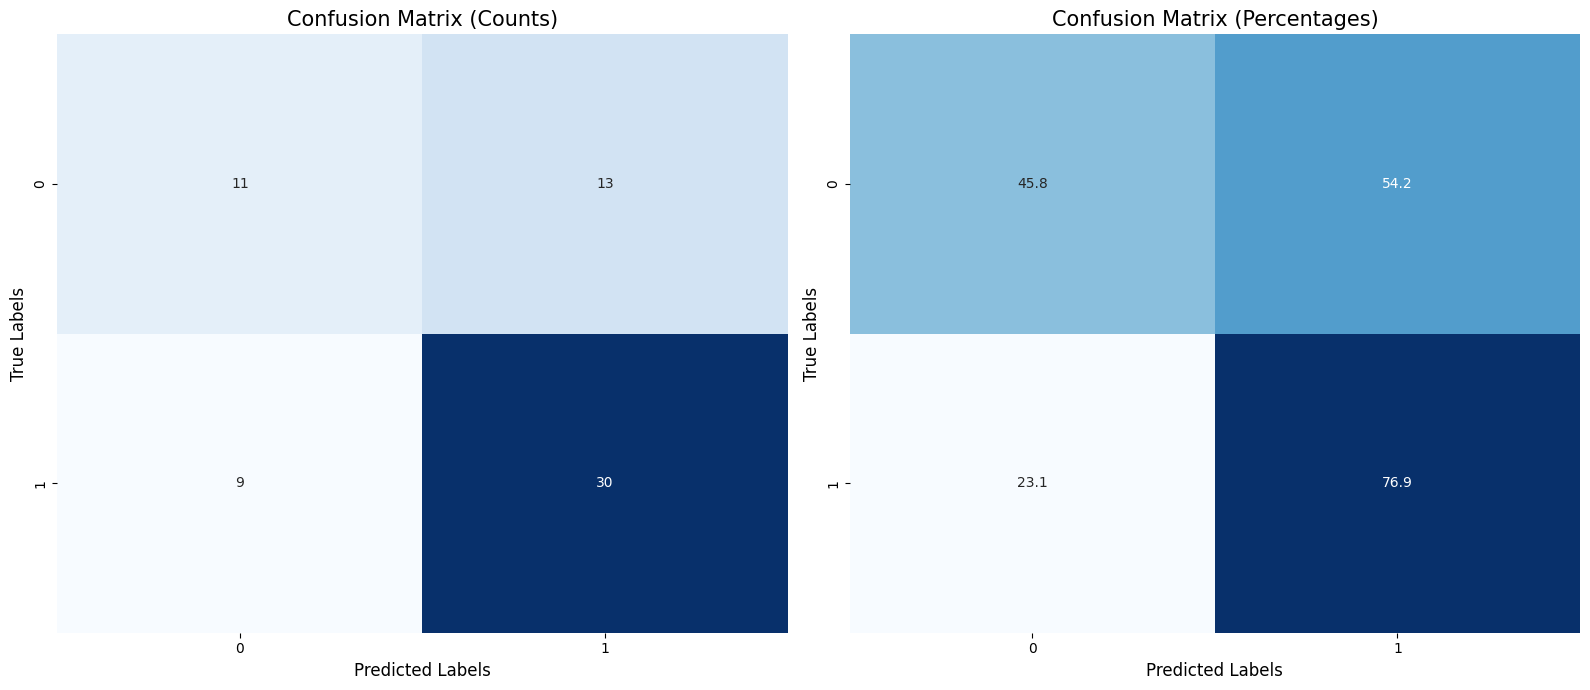


Classification Report:
              precision    recall  f1-score   support

           0     0.5500    0.4583    0.5000        24
           1     0.6977    0.7692    0.7317        39

    accuracy                         0.6508        63
   macro avg     0.6238    0.6138    0.6159        63
weighted avg     0.6414    0.6508    0.6434        63


Accuracy: 0.6508


In [29]:
# Get the confusion matrix
cm = confusion_matrix(y_test, dt_tuned_preds)

# Create a figure with two subplots
plt.figure(figsize=(16, 7))

# Plot 1: Confusion Matrix (Counts)
plt.subplot(1, 2, 1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Counts)', fontsize=15)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)

# Plot 2: Confusion Matrix (Percentages)
plt.subplot(1, 2, 2)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
sns.heatmap(cm_percent, annot=True, fmt='.1f', cmap='Blues', cbar=False)
plt.title('Confusion Matrix (Percentages)', fontsize=15)
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)

plt.tight_layout()
plt.show()

# Print classification report for additional metrics with 4 decimal places
print('\nClassification Report:')
print(classification_report(y_test, dt_tuned_preds, digits=4))

# Print overall accuracy with 4 decimal places
accuracy = accuracy_score(y_test, dt_tuned_preds)
print(f"\nAccuracy: {accuracy:.4f}")

Cross-validation scores: [0.70149254 0.79104478 0.70149254 0.71641791 0.8030303 ]


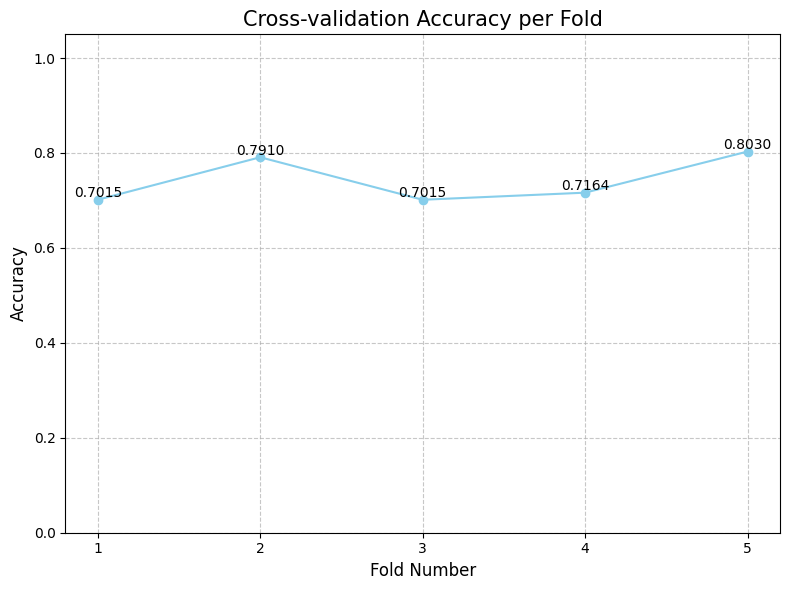

Mean Accuracy: 0.7427
Standard Deviation: 0.0449


In [30]:
dt_model = DecisionTreeClassifier(random_state=42)
# Perform 5-fold cross-validation on the model
cv_scores = cross_val_score(dt_model, X_train_scaled, y_train_balanced, cv=5, scoring='accuracy')

# Print cross-validation results
print("Cross-validation scores:", cv_scores)

# Plotting the cross-validation accuracy for each fold with labels
plt.figure(figsize=(8, 6))
folds = range(1, 6)
plt.plot(folds, cv_scores, marker='o', linestyle='-', color='skyblue', label='Accuracy')

# Add value labels on each point
for i, score in enumerate(cv_scores):
    plt.text(folds[i], score + 0.005, f"{score:.4f}", ha='center', fontsize=10)

plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Cross-validation Accuracy per Fold', fontsize=15)
plt.ylim(0, 1.05)  # Slightly above 1 for space for text
plt.xticks(folds)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Print mean and standard deviation of the cross-validation scores
print(f"Mean Accuracy: {cv_scores.mean():.4f}")
print(f"Standard Deviation: {cv_scores.std():.4f}")